# CITS5508 Lab 4: AdaBoost and Gradient Boosting Regressor on White wine quality

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook compares the performance of AdaBoosting and GradientBoosting on a regressor task. It is addressing a regression task on predicting white wine quality using various physiochemical inputs.<br>

Input variables (based on physicochemical tests):<br>
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol<br>

Output variable (based on sensory data):
- 12 - quality (score between 0 and 10)<br>

An AdaBoost with SVR base estimator and GradientBoost with Decision Tree base estimator are used and judged in performance.

## 1. Setup, Data Cleaning and Visualisation
Import libraries to be used and bring the data in. Clean the data for use.<br>
Perform basic visualisations to have a feel of data.<br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns; sns.set(color_codes=True)
from pandas.plotting import scatter_matrix
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR #for regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings("ignore") #clear warnings

#Prepare the data, separate cols by semi-colon
raw_data = pd.read_csv("winequality-white.csv", delimiter= ";" )

#Quick check for missing values
print("Are there any missing values?", raw_data.isnull().values.any())

#View first few lines and inspect columns
raw_data.head()

Are there any missing values? False


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Looking at the first few lines, we observe that the data is all numerical. Hence, there is no need for text handling. Also no missing values to clean up.

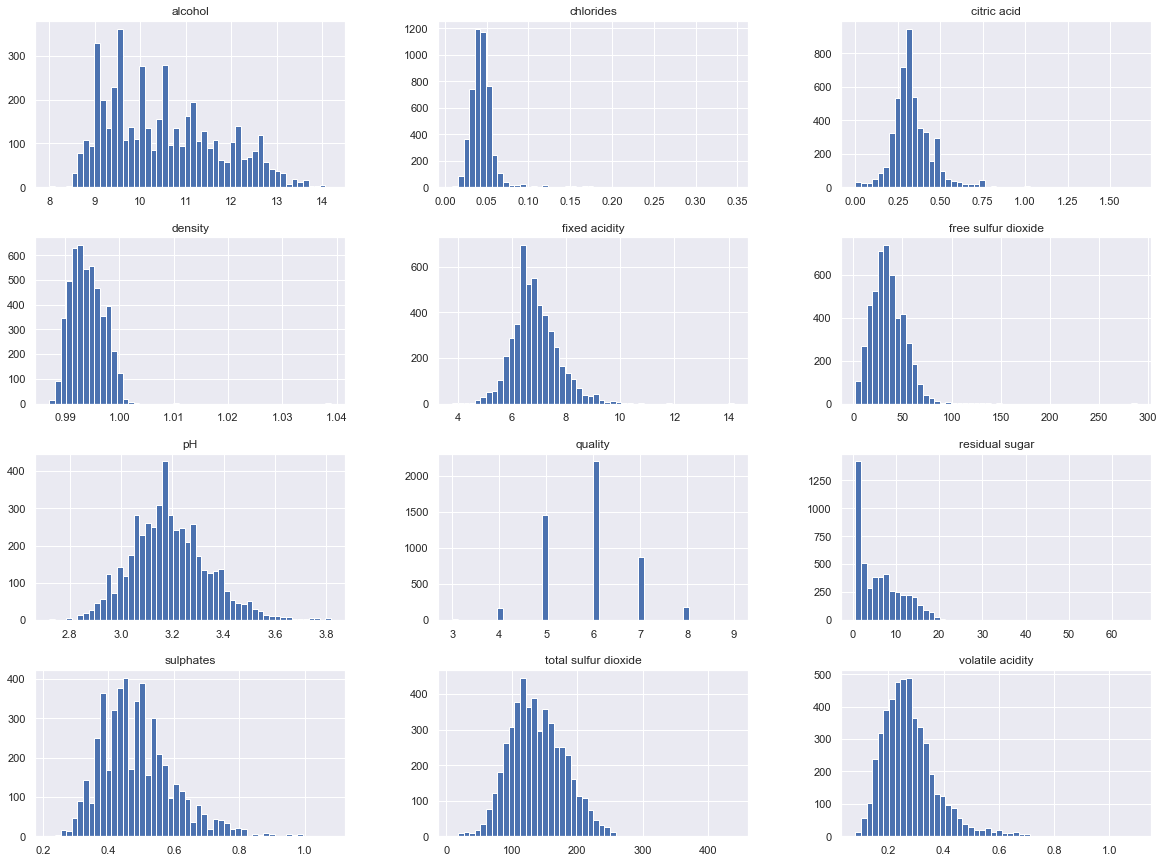

In [2]:
data = raw_data #make a copy
#Generate histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

These are the graphs showing the distribution for each attribute.<br>
**Observations:**
- All attributes appear continuous in the sense that from their scale, there is no significant break in value increments. Except for 'quality', which appears to be integers in the range from 3 to 9. Thus, while this may be a regression task, we would likely need to round the predicted outputs.
- All attributes have some normal distribution adherence. Hence, a StandardScaler for feature scaling would be better than MinMaxScaler. For this reason, standardization was used in the pipeline to normalise the data. In this, firstly the column's mean value is subtracted from every value in the column, then divided by the standard deviation. The resulting distribution has unit variance.
- 'chlorides', 'citric acid', 'density', 'free sulfur dioxide', 'residual_sugar', and 'violatile acidity' have some degree of positive skew. 
- Observing the distribution of the 'quality' label instances, we have an unbalanced dataset favouring the lower half of the range when taking 6 as the median. However, we will not remove the low sample sizes of quality =3 or 9 as this is a regression problem and they can still contribute to the data's signal.

### Visualising Relationship between each feature and quality

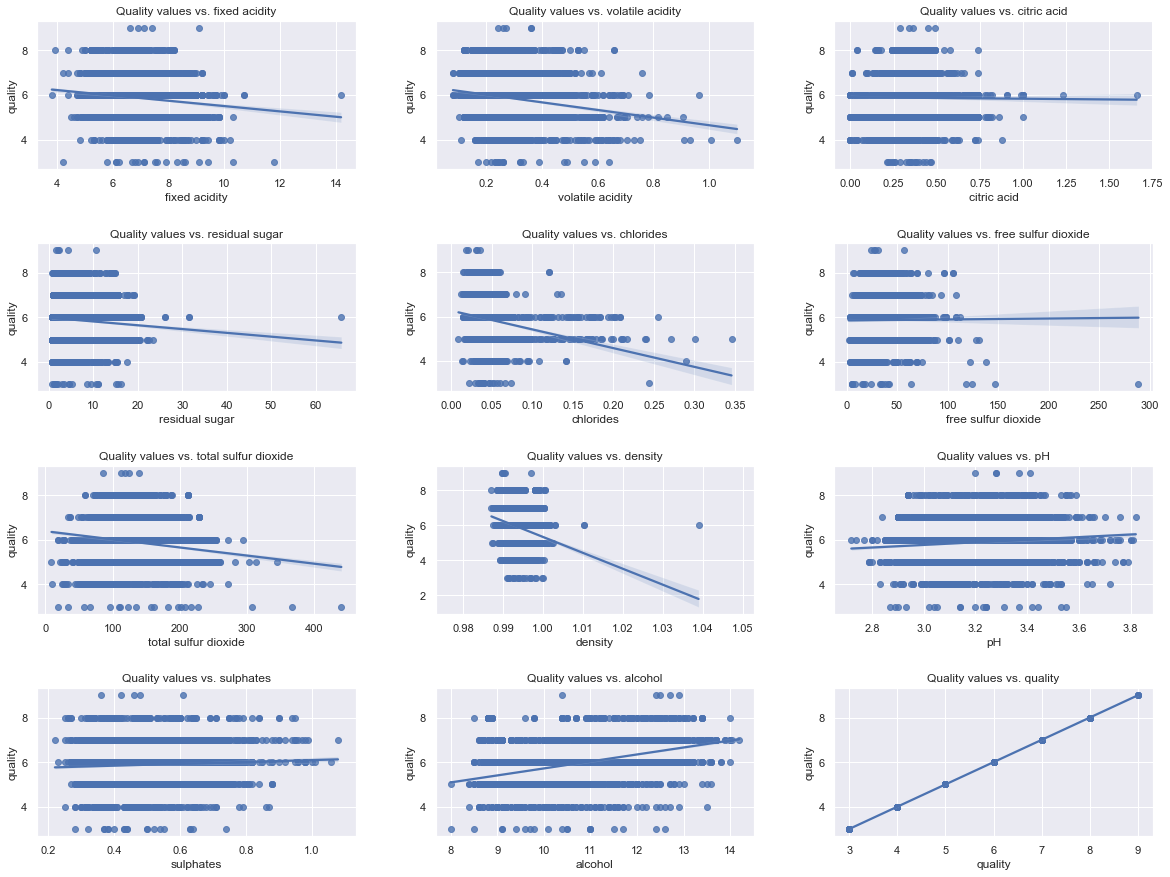

In [3]:
#Plotting each feature vs quality
feat = ['fixed acidity', 'volatile acidity','citric acid', 'residual sugar',
        'chlorides' ,'free sulfur dioxide' ,'total sulfur dioxide',
       'density', 'pH', 'sulphates','alcohol','quality']
#Creating figures 
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace = 0.5, wspace=0.25) #space between plots

#loop to create plots
for i in range(len(feat)): #repeat for every feat
    f = fig.add_subplot(4,3,i+1)
    ax = sns.regplot(x = data[feat[i]], y = data['quality']) #regplot to create scatter plot with line of best fit
    plt.title('Quality values vs. ' + feat[i])
    

**Observations:**
- Focusing on the lines of best fit plotted, there are some features which suggest correlation with quality. However, some with flat lines suggest a weaker relationship.
- This implies that we cannot use any singular feature in isolation to fit a good model. But rather we must capture the full pattern using multiple features.

## 2. Data Splitting and Normalisation
Split dataset then feature scale based on training features. 

In [4]:
#Separate features and labels
y = data["quality"]
X = data.drop("quality",axis=1)

#Split dataset at 85/15 ratio, 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.15, random_state= 0)

#Data Normalisation
std_scaler = StandardScaler()
std_scaler.fit(train_X) #based on training features
train_X_tr = std_scaler.transform(train_X)
test_X_tr = std_scaler.transform(test_X)

**Feature scaling is required for the AdaBoost Regressor** as it uses the Support Vector Regressor as the base estimator. Support Vector Machines are sensitive to feature scales. In a SVR, we are trying to fit as many instances as possible on the narrowest street while limiting margin violations. Thus, the relative scales of different features matter and can affect the fitting process. **Normalised data is used for AdaBoost later.**<br>

**Feature scaling is not required for the GradientBoost Regressor** as it uses decision trees as the weak learner base estimator. Tree based models are constucted in a greedy manner, by choosing the best split points to minimise the loss function. Thus, the relative scales of different features do not matter. **Unscaled data is used for GradientBoost later.** 

## 3. AdaBoost Regressor
Incremental learning by adjusting relative weights of misclassified instances.

In [5]:
#functions used for both AdaBoost and GradientBoost Sections
def displayMSE(title, label1, mse1, label2, mse2): #function for plotting and printing Mean Sq Errors
    plt.scatter(list(range(1,7)), mse1, marker='*')
    plt.plot(list(range(1,7)), mse1, label=label1)
    plt.scatter(list(range(1,7)), mse2, marker='o')
    plt.plot(list(range(1,7)),mse2, label=label2)
    plt.title(title)
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Estimator no.')
    plt.show()
    print(label1,": These are the MSEs for each estimator model from first to last:")
    print(mse1)
    print(label2,": These are the MSEs for each estimator model from first to last:")
    print(mse2)
    
def getPredictionAndRawErrors(model, features_X, labels_y): #returns rounded predictions and raw prediction errors
    pred = model.predict(features_X) #get prediction values
    pred_round = pred.round() #round predictions
    pred_round = pred_round.astype("int64") #change to integer type
    raw_errors = pred_round - labels_y #compute raw prediction errors
    return pred_round, raw_errors

def displayRawErrors(raw_errors1,label1,raw_errors2,label2,title): #plots raw error histograms
    raw_errors1.hist(label=label1, align= "mid")
    raw_errors2.hist(label=label2, align="mid")
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

def displayRawErrors2(raw_errors,title): #plots single raw error histogram
    raw_errors.hist(align= "mid")
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

In [6]:
#Prepare regressor
ada_reg = AdaBoostRegressor( 
    base_estimator=SVR(kernel= "rbf"), 
    n_estimators=6, 
    random_state=0)
ada_reg.fit(train_X_tr, train_y); #fit training set

### 3.1 Mean Squared Errors
Calculate MSE between rounded predictions and the ground truth for all estimators as the model sequentially trains on previous estimator.

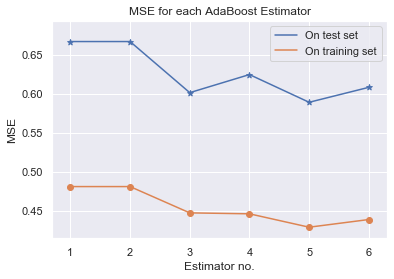

On test set : These are the MSEs for each estimator model from first to last:
[0.6667, 0.6667, 0.6014, 0.6245, 0.5891, 0.6082]
On training set : These are the MSEs for each estimator model from first to last:
[0.4814, 0.4814, 0.4478, 0.4466, 0.4295, 0.4393]


In [7]:
#Get MSE for each stage, from rounded predictions on test and training sets
test_ada_mse = [mean_squared_error(test_y, test_y_ada_pred.round()).round(4) 
             for test_y_ada_pred in ada_reg.staged_predict(test_X_tr)]
train_ada_mse = [mean_squared_error(train_y, train_y_ada_pred.round()).round(4) 
             for train_y_ada_pred in ada_reg.staged_predict(train_X_tr)]

#Call display function
displayMSE("MSE for each AdaBoost Estimator", "On test set", test_ada_mse, "On training set",train_ada_mse )


Note: The AdaBoosting regressor is fitted on the training data.<br>
- As the number of estimators increases, the Mean Squared Errror on the training and test set **generally** decreases as the model learns to generalise on the data better.

- This decrease is more obvious on the training set, as we are simply testing our model on the data it was trained upon. Thus, it should improve as the model corrects upon more predessor estimators and the bias decreases.

- There is a consistently higher MSE on the test set as the model was not trained on it. Hence, the variance comes into play here. We are trying to generalise on data not seen by the model.

- Interestingly, the MSE begins to slightly climb from the 6th estimator on the test set. This is likely due to **overfitting beginning to occur.**

### 3.2 Rounded Predictions and Raw Errors

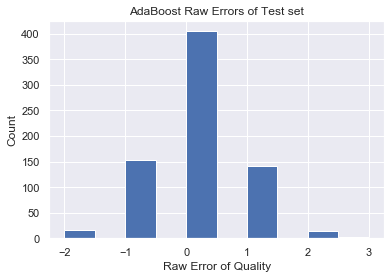

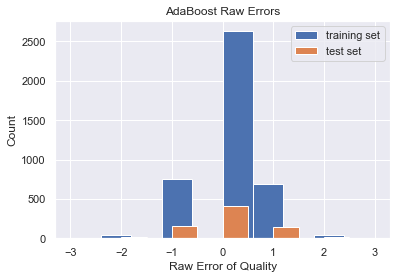

In [8]:
#On training and test set: Call rounded predictions and raw errors function
train_ada_pred, train_ada_raw_errors = getPredictionAndRawErrors(ada_reg, train_X_tr, train_y)
test_ada_pred ,test_ada_raw_errors = getPredictionAndRawErrors(ada_reg, test_X_tr, test_y)

#Call display function
displayRawErrors2(test_ada_raw_errors,"AdaBoost Raw Errors of Test set")
displayRawErrors(train_ada_raw_errors,"training set",test_ada_raw_errors,"test set","AdaBoost Raw Errors")
#test set raw error shown individually due to scale difference with test set.

From the histograms of AdaBoost raw errors on the test and training set, there is a roughly normal distribution. Note there are **slightly more -1 errors** compared to the +1 errors. This implies that the AdaBoost regressor slightly underestimates wine quality more than overestimates it.<br>

This may be due to the aforementioned larger number of instances in the lower half range of the dataset. Thus, the model reflects the imbalance of lower than median (=6) quality by assuming more instances to be lower rather than higher in an ambigious instance.<br>

Overall, the fact both raw error sets have highest peak in the raw error = 0, with significant sub-peaks at +- 1 raw error, indicates that the model is quite good at correctly predicting the quality. If incorrect, it is likely only to be off by 1.

## 4. GradientBoost Regressor
Incremental learning by trying to fit estimator on the residuals of previous redisual errors

In [9]:
#Prepare regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=6,
    random_state=0,
    learning_rate= 0.5,
    warm_start=True)

#gb_reg.fit(train_X, train_y); #fit training set
gb_reg.fit(train_X, train_y); #fit training set

### 4.1 Mean Squared Errors
Calculate MSE between rounded predictions and the ground truth for all estimators as the model sequentially trains on previous estimator.

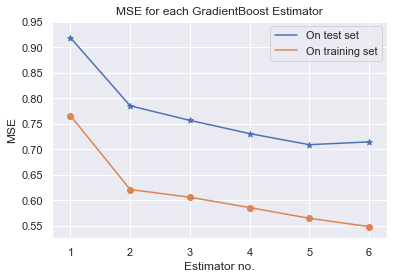

On test set : These are the MSEs for each estimator model from first to last:
[0.9184, 0.785, 0.7565, 0.7306, 0.7088, 0.7143]
On training set : These are the MSEs for each estimator model from first to last:
[0.7656, 0.6209, 0.6058, 0.5856, 0.5645, 0.5482]


In [10]:
#Get MSE at each estimator's stage, with rounded predictions on training and test sets
test_gb_mse = [mean_squared_error(test_y, test_pred.round()).round(4)
         for test_pred in gb_reg.staged_predict(test_X)]
        
train_gb_mse = [mean_squared_error(train_y, train_pred.round()).round(4)
         for train_pred in gb_reg.staged_predict(train_X)]

displayMSE("MSE for each GradientBoost Estimator", "On test set", test_gb_mse, "On training set",train_gb_mse )


Note: The GradientBoosting regressor is fitted on the training data.<br>
We observe the **trade-off between bias and variance here.**<br>

- As the number of estimators increases, the Mean Squared Errror on the training and test set **generally** decreases as the model learns to generalise on the data better by fitting upon previous residual errors. The bias decreases as use more estimators.

- There is a consistently higher MSE on the test set as the model was not trained on it. Hence, the variance comes into play here. As we try to generalise on data not seen by the model.

- Interestingly, the MSE begins to slightly climb from the 6th estimator on the test set. This is likely due to **overfitting on the training set beginning to occur.**

### 4.2 Rounded Predictions and Raw Errors

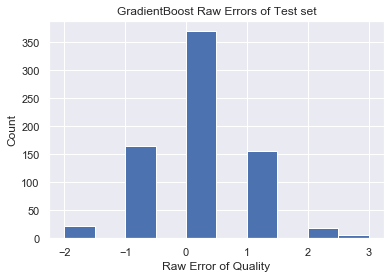

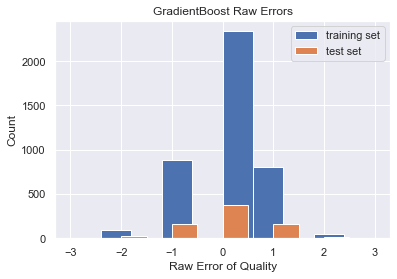

In [11]:
#On training set: Call rounded predictions and raw errors function
train_gb_pred, train_gb_raw_errors = getPredictionAndRawErrors(gb_reg, train_X, train_y)
test_gb_pred ,test_gb_raw_errors = getPredictionAndRawErrors(gb_reg, test_X, test_y)

#Call display function
displayRawErrors2(test_gb_raw_errors,"GradientBoost Raw Errors of Test set")
displayRawErrors(train_gb_raw_errors,"training set",test_gb_raw_errors,"test set","GradientBoost Raw Errors")
#test set raw error shown individually due to scale difference with test set.

From the histograms of GradientBoost raw errors on the test and training set, there is a roughly normal distribution. Note there are **slightly more -1 errors** compared to the +1 errors. This implies that the GradientBoost regressor slightly underestimates wine quality more than overestimates it.<br>

This may be due to the aforementioned larger number of instances in the lower half range of the dataset. Thus, the model reflects the imbalance of lower than median (=6) quality by assuming more instances to be lower rather than higher in an ambigious instance.<br>

Overall, the fact both raw error sets have highest peak in the raw error = 0, with significant sub-peaks at +- 1 raw error, indicates that the model is quite good at correctly predicting the quality. If incorrect, it is likely only to be off by 1.

## 5. Conclusion

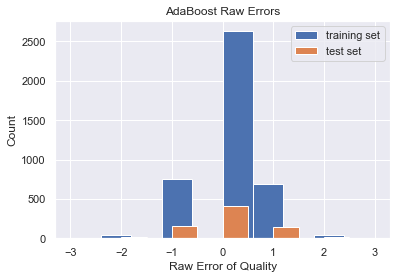

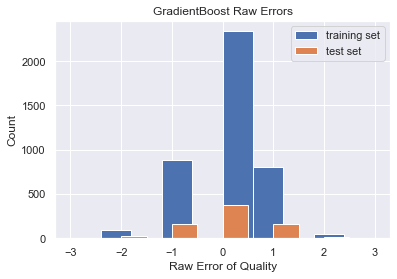

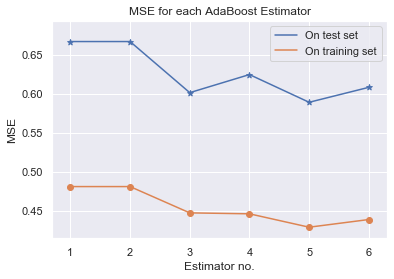

On test set : These are the MSEs for each estimator model from first to last:
[0.6667, 0.6667, 0.6014, 0.6245, 0.5891, 0.6082]
On training set : These are the MSEs for each estimator model from first to last:
[0.4814, 0.4814, 0.4478, 0.4466, 0.4295, 0.4393]


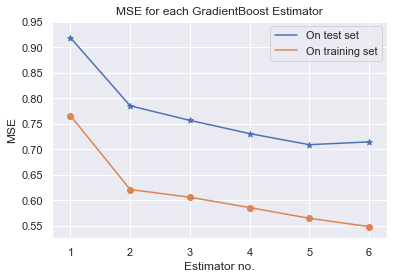

On test set : These are the MSEs for each estimator model from first to last:
[0.9184, 0.785, 0.7565, 0.7306, 0.7088, 0.7143]
On training set : These are the MSEs for each estimator model from first to last:
[0.7656, 0.6209, 0.6058, 0.5856, 0.5645, 0.5482]


In [12]:
#Display all results
displayRawErrors(train_ada_raw_errors,"training set",test_ada_raw_errors,"test set","AdaBoost Raw Errors")
displayRawErrors(train_gb_raw_errors,"training set",test_gb_raw_errors,"test set","GradientBoost Raw Errors")
displayMSE("MSE for each AdaBoost Estimator", "On test set", test_ada_mse, "On training set",train_ada_mse )
displayMSE("MSE for each GradientBoost Estimator", "On test set", test_gb_mse, "On training set",train_gb_mse )


#### Comparing the Performances

**Overall the similarities between AdaBoost and GradientBoost regressors are:**
- Model generally improves with reduced Mean Squared Error as the number of estimators increase. Meaning that the model improvement adheres to the general idea of sequential training by correcting the previous estimator.

- The MSE is consistently higher for the test set compared to the training set, as the model fails to generalise equally as well on data unseen.

- The MSE reduction should continue for validation on the training set as estimators increase. As the model fits the training data better, it should perform better on the training data. **However**, we note that MSE improvement on unseen data (the test set) has a limit. After the second last estimator, the MSE seems to trend upwards. The model begins to overfit on the training data and variance increases.

- On raw errors, both regressors have similar histogram distributions. I.e. both models correctly predict the wine quality most of the time, with incorrect predictions being mostly off by 1 and slightly favouring an underestimation.

**Differences include:**
- The final MSEs indicators. AdaBoosting regressor is the best at generalising on the test set with a MSE= 0.6082 compared to GradientBoosting's 0.7143. AdaBoost also predicts better on the training set with MSE= 0.4393 compared to GradientBoost's 0.5482.<br>
- The shape of AdaBoost's MSE graph is zigzagged compared to GradientBoost's smoothly curving graph. The AdaBoost model works by increasing the weights of previous incorrect training instances and training sequentially. We used a Support Vector Regressor with feature scaling as a base estimator. While the GradientBoost model works by trying to fit on the residual errors of previous regressor's predictions. The base estimator is a decision tree. **Due to the differences approaches in adjusting weights of incorrect instances or in fitting on residual errors, the MSE shape arises**.
- In this case, the AdaBoost regressor's method captures the data's underlying pattern and generalises on unseen data better than the GradientBoost regressor's method.